In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using Random

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function vmp(::Type{T}, n, iters, data) where T
    model = Model()
    
    mean_mean = datavar(model, :mean_mean, PointMass{T})
    mean_prec = datavar(model, :mean_prec, PointMass{T})
    
    prec_α = datavar(model, :prec_α, PointMass{T})
    prec_θ = datavar(model, :prec_θ, PointMass{T})
            
    meanv = randomvar(model, :μ)
    precv = randomvar(model, :τ)
            
    mean_gaussian_node = make_node(model, NormalMeanPrecision, meanv, mean_mean, mean_prec)
    prec_gamma_node    = make_node(model, Gamma, precv, prec_α, prec_θ)

    y = datavar(model, :y, PointMass{T})
    
    gmpnode = make_node(model, NormalMeanPrecision, y, meanv, precv, factorisation = ( (1,) , (2,) , (3,) ))

    activate!(model)

    currentmeanv = Ref(convert(NormalMeanPrecision{T}, NormalMeanPrecision(0.0, 0.00001)))
    currentprecv = Ref(convert(Gamma{T}, Gamma(0.1, 10.0)))
    
    setmarginal!(gmpnode, :μ, currentmeanv[])
    setmarginal!(gmpnode, :τ, currentprecv[])

    subscribe!(getmarginal(meanv), (d) -> currentmeanv[] = getdata(d))
    subscribe!(getmarginal(precv), (d) -> currentprecv[] = getdata(d))

    fe_scheduler = PendingScheduler()

    fe = Vector{T}()
    ma = Vector{NormalMeanPrecision{T}}(undef, n)
    pa = Vector{Gamma{T}}(undef, n)

    subscription = subscribe!(score(T, BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d)) 
    
    for i in 1:n
        tmp1 = currentmeanv[]
        tmp2 = currentprecv[]

        for j in 1:iters
            # update!(y, convert(T, data[i]))
            update!(mean_mean, mean(tmp1))
            update!(mean_prec, precision(tmp1))
            update!(prec_α, shape(tmp2))
            update!(prec_θ, scale(tmp2))
            update!(y, convert(T, data[i]))
            release!(fe_scheduler)
        end
        
        ma[i] = currentmeanv[]
        pa[i] = currentprecv[]
    end
    
    unsubscribe!(subscription)
    
    return ma, pa, fe
end

vmp (generic function with 1 method)

In [3]:
Random.seed!(1234)

realprecision = 0.01999
realmean = -200.0
n = 2000
iters = 5

data = rand(Normal(realmean, sqrt(1.0 / realprecision)), (n, ));

In [4]:
@time ma, pa, fe = vmp(Float64, n, iters, data); # Initial compilation

 12.555342 seconds (22.11 M allocations: 1.141 GiB, 3.05% gc time)


In [5]:
@time ma, pa, fe = vmp(Float64, n, iters, data); # Subsequent runs

  0.186074 seconds (1.86 M allocations: 84.322 MiB, 16.30% gc time)


In [6]:
@btime ma, pa, fe = vmp($Float64, $n, $iters, $data); # Benchmark

  132.138 ms (1861359 allocations: 84.32 MiB)


In [7]:
function plot_results(ma, pa, fe)
    plot_fe = plot(vec(sum(reshape(fe, (iters, n)), dims = 2)))

    plot_mean = plot(mean.(ma), ribbon = var.(ma), label = :prediction)
    plot_mean = plot!(plot_mean, [ realmean ], seriestype=:hline, label = :real)

    plot_prec = plot(mean.(pa), label = :prediction, yscale = :log10)
    plot_prec = plot!(plot_prec, [ realprecision ], seriestype=:hline, label = :real)

    plot(plot_mean, plot_prec, plot_fe, layout = @layout([ a b; c ]), size = (1000, 400))
end

plot_results (generic function with 1 method)

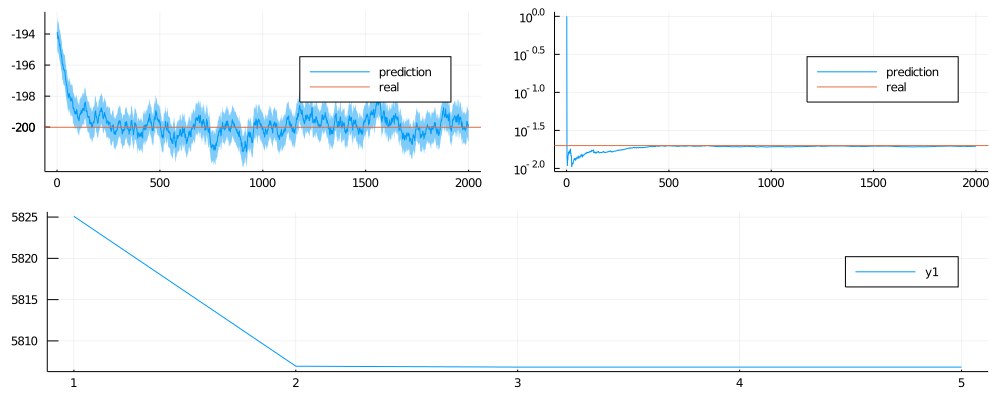

In [8]:
plot_results(ma, pa, fe)

In [9]:
@time bma, bpa, bfe = vmp(BigFloat, n, iters, data); # BigFloats initial compilation

  8.254813 seconds (13.73 M allocations: 673.640 MiB, 2.13% gc time)


In [10]:
@time bma, bpa, bfe = vmp(BigFloat, n, iters, data); # BigFloats subsequent runs

  3.476863 seconds (6.43 M allocations: 289.774 MiB, 2.24% gc time)


In [11]:
@btime bma, bpa, bfe = vmp(BigFloat, n, iters, data); # BigFloats benchmark

  3.324 s (6428977 allocations: 289.77 MiB)


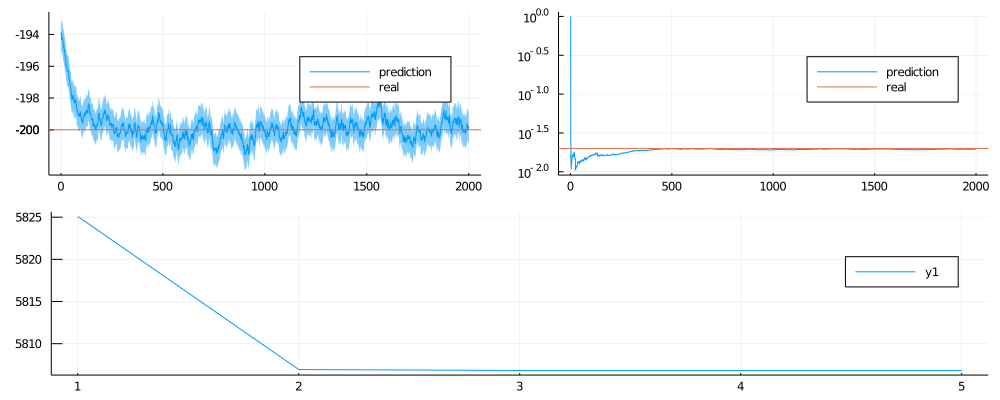

In [12]:
plot_results(bma, bpa, bfe)